In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook
import pandas as pd
import numpy as np
from util import *

from sklearn.model_selection import train_test_split
from sklearn import metrics
from skater.core.global_interpretation.interpretable_models.brlc import BRLC
from skater.core.global_interpretation.interpretable_models.bigdatabrlc import BigDataBRLC

# Read the datasets
df = pd.read_csv('LoanStats3a.csv', skiprows=1)
df = df[df.loan_status.isin(['Fully Paid','Charged Off'])]

In [2]:
#remove columns that are entirely null
for column in df.columns:
    if df[column].isnull().mean() >= .99:
        df = df.drop(column, 1)
        
        
#remove columns with constant values
for column in df.columns:
    if df[column].unique().shape[0] == 1:
        df = df.drop(column, 1)  

### The Data

In [3]:
print("The data has {0} rows and {1} fields".format(*df.shape))
df.head(1).T

The data has 39786 rows and 45 fields


,0
loan_amnt,5000
funded_amnt,5000
funded_amnt_inv,4975
term,36 months
int_rate,10.65%
installment,162.87
grade,B
sub_grade,B2
emp_title,NaN
emp_length,10+ years


In [4]:
# Quick Summary
df.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,...,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,chargeoff_within_12_mths,pub_rec_bankruptcies,tax_liens
count,39786.000000,39786.000000,39786.000000,39786.000000,3.978600e+04,39786.000000,39786.000000,39786.000000,14059.000000,2791.000000,...,39786.000000,39786.000000,39786.000000,39786.000000,39786.000000,39786.000000,39730.0,39730.0,39089.000000,39747.0
mean,11231.360277,10958.722289,10409.018679,324.733637,6.897907e+04,13.317794,0.146534,0.869049,35.901913,69.747402,...,9855.428956,2276.340372,1.388777,96.988913,12.677006,2679.087785,0.0,0.0,0.043286,0.0
std,7464.542832,7194.076908,7135.760122,208.923212,6.376263e+04,6.678300,0.491826,1.070069,22.017895,43.805070,...,7143.373160,2632.432496,7.398941,697.937190,150.181945,4443.389974,0.0,0.0,0.204381,0.0
min,500.000000,500.000000,0.000000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
25%,5500.000000,5400.000000,5000.000000,167.080000,4.050000e+04,8.180000,0.000000,0.000000,18.000000,22.500000,...,4620.910000,663.045000,0.000000,0.000000,0.000000,218.025000,0.0,0.0,0.000000,0.0
50%,10000.000000,9650.000000,8975.000000,280.610000,5.900000e+04,13.410000,0.000000,1.000000,34.000000,90.000000,...,8000.000000,1352.805000,0.000000,0.000000,0.000000,549.425000,0.0,0.0,0.000000,0.0
75%,15000.000000,15000.000000,14400.000000,430.780000,8.234250e+04,18.600000,0.000000,1.000000,52.000000,104.000000,...,14000.000000,2845.567500,0.000000,0.000000,0.000000,3292.122500,0.0,0.0,0.000000,0.0
max,35000.000000,35000.000000,35000.000000,1305.190000,6.000000e+06,29.990000,11.000000,8.000000,120.000000,129.000000,...,35000.020000,23886.470000,180.200000,29623.350000,7002.190000,36115.200000,0.0,0.0,2.000000,0.0


In [5]:
df['int_rate'] = df['int_rate'].apply(process_int_rate)
df['term'] = df['term'].apply(process_term)
df['emp_length'] = df['emp_length'].apply(process_emp_length)
df['revol_util'] = df['revol_util'].apply(process_revol_util)
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].fillna(0)

In [6]:
df.head(2).T

,0,1
loan_amnt,5000,2500
funded_amnt,5000,2500
funded_amnt_inv,4975,2500
term,36,60
int_rate,10.65,15.27
installment,162.87,59.83
grade,B,C
sub_grade,B2,C4
emp_title,NaN,Ryder
emp_length,10,1


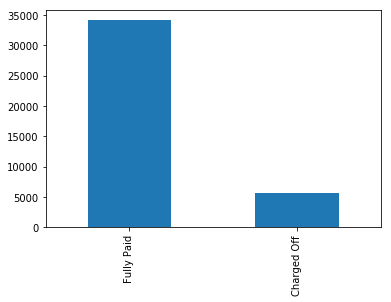

In [7]:
%matplotlib inline
df.loan_status.value_counts().plot(kind='bar')

### DTI also a factor

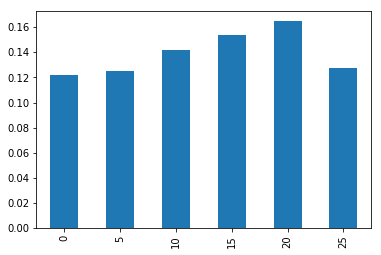

In [8]:
def_by_dti = df.set_index('dti').groupby(by=(lambda x: round_to_nearest(x, 5), 'loan_status'))['loan_amnt'].count().unstack()
def_by_dti = (def_by_dti['Charged Off'] / def_by_dti.sum(axis=1))
ax = def_by_dti.plot(kind = 'bar')

### Small business loans are much riskier

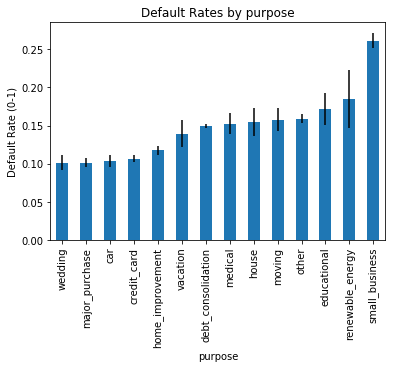

In [9]:
def_rates_by_categorical(df, 'purpose', with_variance=True)

### (Light) Feature Engineering

In [10]:
df_ = df.copy()

domain_columns = ['loan_amnt', 
                  'term', 
                  'annual_inc', 
                  'installment_over_income', 
                  'has_employer_info',
                  'is_employed',
                  'dti',
                  'inq_last_6mths',
                  'delinq_2yrs',
                  'open_acc',
                  'int_rate',
                  'revol_util',
                  'pub_rec_bankruptcies',
                  'revol_bal',
                  'requested_minus_funded',
                  'debt_to_income'
                 ]

#features to engineer
df_['requested_minus_funded'] = df_['loan_amnt'] - df_['funded_amnt']
df_['has_employer_info'] = df_['emp_title'].isnull()
df_['installment_over_income'] = df_['installment'] / df_['annual_inc']
df_['is_employed'] = df_['emp_length'].isnull()
df_['debt_to_income'] = (df_['revol_bal'] + df_['funded_amnt']) / df['annual_inc']



#dummy section
dummy_columns = ['home_ownership'] #'grade', 'addr_state'

for column in dummy_columns:
    dummies = pd.get_dummies(df_[column], prefix="{}_is".format(column))
    columns_to_add = dummies.columns.values[:-1]
    dummies = dummies[columns_to_add]
    df_ = df_.join(dummies)
    domain_columns.extend(columns_to_add)

df_["emp_title"] = df_["emp_title"].fillna("None")
df_['target'] = df_['loan_status'].apply(lambda x: 0 if x == 'Charged Off' else 1)
domain_columns = list(set(domain_columns))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(df_[domain_columns].values)
X_df = pd.DataFrame(X)

In [11]:
# input_data = df_[domain_columns]
# input_data.head(2)
# input_data["has_employer_info"] = input_data["has_employer_info"].astype('category')
# input_data["has_employer_info_Encoded"] = input_data["has_employer_info"].cat.codes

# input_data["is_employed"] = input_data["is_employed"].astype('category')
# input_data["is_employed_Encoded"] = input_data["is_employed"].cat.codes

# input_data = input_data.drop(['has_employer_info', 'is_employed'], axis=1)
# # # Remove NaN values
# input_data_clean = input_data.dropna()

In [12]:
# input_data_clean = input_data_clean[["is_employed_Encoded", "has_employer_info_Encoded"]]
# print(input_data_clean.dtypes)
# input_data_clean.head(2)

In [27]:
# Default test split-size = 0.25
y = df_['target']
Xtrain, Xtest, ytrain, ytest = train_test_split(X_df, y) # split
# Target Labels: 1:positive 0:negative
np.unique(ytrain)
print(len(Xtrain))
print(type(Xtrain))
print(type(ytrain))

29839
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [14]:
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
26047,-0.413807,1.116878,-0.275496,-1.537505,-0.342831,-0.190173,-0.166882,1.367694,-0.606139,-0.297942,-0.521376,0.370910,-0.288856,0.486513,-0.049692,0.088648,0.122377,-0.008684,-0.257055,-0.209847
5842,-1.022739,-0.895353,-0.349269,-1.848966,-1.212065,-0.190173,-0.166882,-1.695259,-0.606139,-0.297942,-0.521376,-0.834805,-0.288856,-0.517223,-0.049692,-0.835512,1.056908,-0.008684,-0.257055,-0.209847
36912,0.047081,1.116878,-1.068589,0.254889,-0.726474,-0.190173,-0.166882,-0.158495,-0.606139,-0.297942,1.296830,-0.164963,-0.288856,1.521552,-0.049692,2.690314,0.122377,-0.008684,-0.257055,-0.209847
3337,1.029569,-0.895353,1.599968,-0.418943,0.105201,-0.190173,-0.166882,0.913009,-0.606139,-0.297942,-0.748652,0.102973,-0.288856,-0.500347,-0.049692,-0.118405,-0.812153,-0.008684,-0.257055,-0.209847
280,0.295849,-0.895353,-0.440934,0.108144,1.054919,-0.190173,-0.166882,1.519256,-0.606139,-0.297942,0.160451,-0.432900,-0.288856,0.016012,-0.049692,0.671934,1.056908,-0.008684,-0.257055,-0.209847


In [17]:
sbrl_big = BigDataBRLC(sub_sample_percentage=0.1, min_rule_len=1, max_rule_len=3, iterations=10000, n_chains=3, 
                       surrogate_estimator="SVM", drop_features=True)
n_x, n_y = sbrl_big.subsample(Xtrain, ytrain, pos_label=1)
print(len(n_x))

2985


In [18]:
# Create an instance of the estimator
from timeit import default_timer as timer
from datetime import timedelta
start = timer()
# Train a model, by default discretizer is enabled. So, you wish to exclude features then exclude them using 
# the undiscretize_feature_list parameter
model = sbrl_big.fit(n_x, n_y, bin_labels='default')
elapsed = (timer() - start)
print(timedelta(seconds=round(elapsed)))

Eclat


parameter specification:


 tidLists
 support
 minlen
 maxlen
            target
   ext


    FALSE
     0.1
      1
      3
 frequent itemsets
 FALSE



algorithmic control:


 sparse
 sort
 verbose


      7
   -2
    TRUE



Absolute minimum support count:
 
255
 



create itemset ... 

set transactions ...
[80 item(s),
 2557 transaction(s)] done 
[0.00s].


sorting and recoding items ... 
[80 item(s)] 
done [0.00s].


creating bit matrix ... 
[80 row(s), 2557 column(s)] 
done [0.00s].

writing  ... 
[712 set(s)] done 
[0.00s].

Creating S4 object  ... 
done 
[0.00s].

Eclat


parameter specification:


 tidLists
 support
 minlen
 maxlen
            target
   ext


    FALSE
     0.1
      1
      3
 frequent itemsets
 FALSE



algorithmic control:


 sparse
 sort
 verbose


      7
   -2
    TRUE



Absolute minimum support count:
 
42
 



create itemset ... 

set transactions ...
[80 item(s),
 428 transaction(s)] done 
[0.00s].


sorting and recoding items ... 
[80 item(

In [19]:
# Features considered
sbrl_big.feature_names

Index(['0_q_label', '1_q_label', '2_q_label', '3_q_label', '4_q_label',
       '5_q_label', '6_q_label', '7_q_label', '8_q_label', '9_q_label',
       '10_q_label', '11_q_label', '12_q_label', '13_q_label', '14_q_label',
       '15_q_label', '16_q_label', '17_q_label', '18_q_label', '19_q_label'],
      dtype='object')

In [20]:
sbrl_big.print_model()

The rules list is : 

If      {X4_q_label=4,X13_q_label=4} (rule[372]) then positive probability = 0.85545723

else if {X4_q_label=1} (rule[357]) then positive probability = 0.93582888

else if {X4_q_label=4} (rule[438]) then positive probability = 0.65770171

else if {X0_q_label=4} (rule[34]) then positive probability = 0.77126100

else  (default rule)  then positive probability = 0.89765828



In [ ]:
sbrl_big.save_model("model1.pkl")

In [ ]:
# quick look at the test set
Xtest[0:3]

In [30]:
# Discretize the testing set similar to train set
new_X_test = sbrl_big.discretizer(Xtest, n_x.columns, labels_for_bin='default')
#ytest = n_y
new_X_test.head(2)
print(new_X_test.shape[0])
print(len(ytest))


new_X_train = sbrl_big.discretizer(Xtrain, n_x.columns, labels_for_bin='default')
print(new_X_train.shape[0])
print(len(ytrain))

9947
9947
29839
29839


### Computing performance metrics for BRLC for train and test

In [32]:
results_train_sbrl = sbrl_big.predict_proba(new_X_train)
fpr_sbrl, tpr_sbrl, thresholds_sbrl = metrics.roc_curve(ytrain, results_train_sbrl[1], pos_label=1)
roc_auc_sbrl = metrics.auc(fpr_sbrl, tpr_sbrl)
print("AUC-ROC using SBRL(Train): {}".format(roc_auc_sbrl))
print("Accuracy(Train): {}".format(metrics.accuracy_score(ytrain, sbrl_big.predict(new_X_train)[1])))

print("-----------------------------------------------------------------\n")

results_test_sbrl = sbrl_big.predict_proba(new_X_test)
fpr_sbrl, tpr_sbrl, thresholds_sbrl = metrics.roc_curve(ytest ,results_test_sbrl[1], pos_label=1)
roc_auc_sbrl = metrics.auc(fpr_sbrl, tpr_sbrl)
print("AUC-ROC using SBRL(Test): {}".format(roc_auc_sbrl))
print("Accuracy(Test): {}".format(metrics.accuracy_score(ytest, sbrl_big.predict(new_X_test)[1])))

AUC-ROC using SBRL(Train): 0.6474185994031538
Accuracy(Train): 0.8563959918227823
-----------------------------------------------------------------

AUC-ROC using SBRL(Test): 0.6485615645320563
Accuracy(Test): 0.86076203880567


### Evaluating performance of a black box classifier

In [33]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
svm = LinearSVC(random_state=0)
est = CalibratedClassifierCV(svm)
est.fit(Xtrain, ytrain)

CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0),
            cv=3, method='sigmoid')

In [36]:
results_train_svm = pd.DataFrame(est.predict_proba(Xtrain))[1] 
results_test_svm = pd.DataFrame(est.predict_proba(Xtest))[1]

In [38]:
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(ytrain, results_train_svm, pos_label=1)
roc_auc_svm = metrics.auc(fpr_svm, tpr_svm)
print("AUC-ROC using SVM(Train): {}".format(roc_auc_svm))
print("Accuracy(Test): {}".format(est.score(Xtrain, ytrain)))

print("-----------------------------------------------------------------\n")

fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(ytest, results_test_svm, pos_label=1)
roc_auc_svm = metrics.auc(fpr_svm, tpr_svm)
print("AUC-ROC using SVM(Test): {}".format(roc_auc_svm))
print("Accuracy(Test): {}".format(est.score(Xtest, ytest)))

AUC-ROC using SVM(Train): 0.6890253773348752
Accuracy(Test): 0.856228425885586
-----------------------------------------------------------------

AUC-ROC using SVM(Test): 0.6968924902832345
Accuracy(Test): 0.860661505981703
